### 1. Importation des bibliothèques nécessaires

In [1]:

import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
# from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns

### 2. Chargement des donées


In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')


    


train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28855 entries, 0 to 28854
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            28855 non-null  int64  
 1   date          28855 non-null  float64
 2   hour          28855 non-null  float64
 3   bc_price      28855 non-null  float64
 4   bc_demand     28855 non-null  float64
 5   ab_price      28855 non-null  float64
 6   ab_demand     28855 non-null  float64
 7   transfer      28855 non-null  float64
 8   bc_price_evo  28855 non-null  object 
dtypes: float64(7), int64(1), object(1)
memory usage: 2.0+ MB


In [3]:
train_df_plot = train_df.copy()  # Copie du DataFrame original
train_df_plot['bc_price_evo'] = train_df_plot['bc_price_evo'].replace({'UP': 1, 'DOWN': 0})
train_df_plot = train_df_plot.drop('id', axis=1)
# plt.figure(figsize=(12, 5))
# sns.pairplot(train_df_plot)
# plt.show()

/tmp/ipykernel_19276/1464042039.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df_plot['bc_price_evo'] = train_df_plot['bc_price_evo'].replace({'UP': 1, 'DOWN': 0})


Text(0.5, 1.0, 'Matrice de Corrélation')

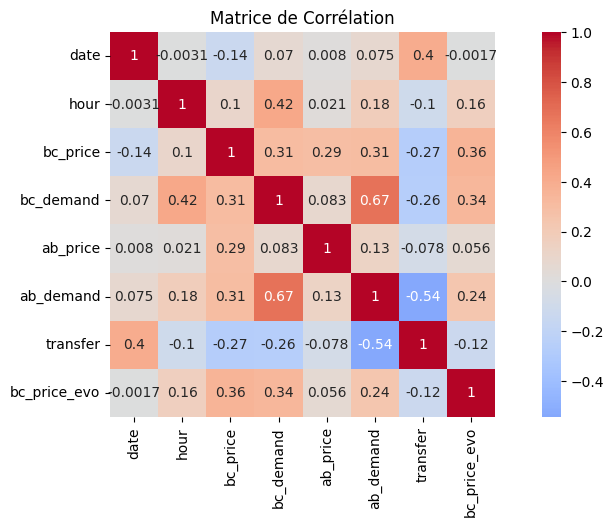

In [4]:
# Calcul de la matrice de corrélation
correlation_matrix = train_df_plot.corr()
plt.figure(figsize=(12, 5))
sns.heatmap(correlation_matrix, 
            annot=True,  # Affiche les valeurs
            cmap='coolwarm',  # Palette de couleurs
            center=0,  # Centre la colormap à 0
            square=True)  # Forme carrée
plt.title('Matrice de Corrélation')

### 3. Traitement préliminaires des données chargées:

In [5]:
# Droppping unnecessary columns
X_train = train_df.drop(columns=['id', 'bc_price_evo'])
Y_train = train_df['bc_price_evo']

X_test = test_df.drop(columns=['id'])

# Dropping unecessary features:
# X_train = X_train.drop(columns=['date', 'ab_price', 'transfer', 'hour'])
# X_test = X_test.drop(columns=['date', 'ab_price', 'transfer', 'hour'])
X_train = X_train.drop(columns=['date'])
X_test = X_test.drop(columns=['date'])

# Normalisation
X_train = (X_train- X_train.mean()) / X_train.std() 
X_test = (X_test - X_test.mean()) / X_test.std()


# Replacing UP and DOWN classing to 1 and 0
Y_train = Y_train.replace({'UP': 1, 'DOWN': 0})

Y_train.info()
X_train.info()



<class 'pandas.core.series.Series'>
RangeIndex: 28855 entries, 0 to 28854
Series name: bc_price_evo
Non-Null Count  Dtype
--------------  -----
28855 non-null  int64
dtypes: int64(1)
memory usage: 225.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28855 entries, 0 to 28854
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hour       28855 non-null  float64
 1   bc_price   28855 non-null  float64
 2   bc_demand  28855 non-null  float64
 3   ab_price   28855 non-null  float64
 4   ab_demand  28855 non-null  float64
 5   transfer   28855 non-null  float64
dtypes: float64(6)
memory usage: 1.3 MB


/tmp/ipykernel_19276/1308478023.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_train = Y_train.replace({'UP': 1, 'DOWN': 0})


### 4. Spliting the data:

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)


### 5. Creating Dataset:

In [7]:
class ElectricityDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.Y = torch.tensor(Y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
train_dataset = ElectricityDataset(X_train, Y_train)
val_dataset = ElectricityDataset(X_val, Y_val)


### 6. Creating the model:

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, inputDim):
        super().__init__()
        self.activation = nn.ReLU()
        self.model = nn.Sequential(
            nn.Linear(inputDim, 32),
            nn.BatchNorm1d(32),
            self.activation,
            
            
            nn.Linear(32, 512),
            nn.BatchNorm1d(512),
            self.activation,
            
            

            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            self.activation,
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            self.activation,
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            self.activation,
            
            nn.Linear(512, 16),
            nn.BatchNorm1d(16),
            self.activation,



 


            
            
           
            
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.model(x)

    def __str__(self):
        return f"{self.model}"
        

### 7 Definitions of metrics, model, loss, etc.

In [9]:


LR = 1e-4
BATCH_SIZE = 256
EPOCHS = 200
WEIGHT_DECAY = 1e-5





inputDim = len(X_train.columns)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNetwork(inputDim).to(device)
# model.apply(initialize_weights)

model_name = input("Wanna load a model ? (give its name)")
if model_name == "":
    model_name = "lastModel"
    
try:
    model.load_state_dict(torch.load("./models/" + model_name + ".pth"))
    print(f"Model {model_name} loaded")

except FileNotFoundError:
    print("No model found, creating a new one")
    
    
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay = WEIGHT_DECAY)
criterion = nn.BCEWithLogitsLoss()

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25, verbose=True)
# - step_size=10 : diminue le taux d'apprentissage toutes les x époques
# - gamma=0.1 : multiplie le taux d'apprentissage par x à chaque étape


No model found, creating a new one


/home/shaun/4if/4IF_ML_TP1/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### 8. DataLoaders:

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 9. Training function:

In [11]:

def train(model, train_loader, val_loader, epochs, optimizer, criterion, device, file, scheduler):
    training_accruacies_epoch = []
    validation_accruacies_epoch = []
    training_losses_epoch = []
    validation_losses_epoch = []

    for epoch in range(epochs):

        #############################
        ########## TRAINING #########
        #############################

        model.train(True)

        # Metrics:
        running_training_loss = 0.0
        correct_guess_training = 0
        total_training = 0

        for i, data in enumerate(train_loader):
            inputs, labels = data

            # Moving to the device:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero your gradients for every batch!
            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(inputs)

            # Compute the loss and its gradients
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()  # compute gradients

            # Adjust learning weights
            optimizer.step()

            # Update metrics:
            running_training_loss += loss.item()
            pred = torch.round(torch.sigmoid(outputs)).squeeze()
            correct_guess_training += (pred == labels).sum().item()
            total_training += labels.size(0)
            
            
            # print("Prediction:", pred)
            # print("Label:", pred)
            

        # Accuracy:
        training_accuracy = correct_guess_training / total_training
        avg_training_loss = running_training_loss / (i + 1)

        #############################
        ######## VALIDATION #########
        #############################

        running_vloss = 0.0
        correct_guess_validation = 0
        total_validation = 0
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(val_loader):
                vinputs, vlabels = vdata

                # Move to device
                vinputs = vinputs.to(device)
                vlabels = vlabels.to(device)

                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels.unsqueeze(1))
                running_vloss += vloss.item()

                pred = torch.round((torch.sigmoid(voutputs))).squeeze()
                correct_guess_validation += (pred == vlabels).sum().item()
                total_validation += vlabels.size(0)

        # Accuracy:
        validation_accuracy = correct_guess_validation / total_validation
        avg_vloss = running_vloss / (i + 1)

        # Maj scheduler
        scheduler.step(avg_vloss)

        # Print the results for this epoch
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Training Loss: {avg_training_loss:.4f} - "
              f"Training Accuracy: {training_accuracy*100:.4f} % - "
              f"Validation Loss: {avg_vloss:.4f} - "
              f"Validation Accuracy: {validation_accuracy*100:.4f} % - "
              f"Learning rate : {scheduler.get_last_lr()}\n")
        
        file.write(f"Epoch {epoch+1}/{epochs} - "
              f"Training Loss: {avg_training_loss:.4f} - "
              f"Training Accuracy: {training_accuracy*100:.4f} % - "
              f"Validation Loss: {avg_vloss:.4f} - "
              f"Validation Accuracy: {validation_accuracy*100:.4f} % - "
              f"Learning rate : {scheduler.get_last_lr()}\n")

        # Save the metrics for plotting
        training_accruacies_epoch.append(training_accuracy)
        validation_accruacies_epoch.append(validation_accuracy)
        training_losses_epoch.append(avg_training_loss)
        validation_losses_epoch.append(avg_vloss)

    return model, training_accruacies_epoch, validation_accruacies_epoch, training_losses_epoch, validation_losses_epoch


### 10. Training the model:

In [12]:
information_writing_string = f"""Starting training:
\t - Model: {model}
\t - Learning rate: {LR:.1e}
\t - Batch size: {BATCH_SIZE}
\t - Epochs: {EPOCHS}
\t - Weight decay: {WEIGHT_DECAY}
\t - Device: {device} \n
\t - Loss function : {criterion} \n"""

print(information_writing_string)

# Create the file:
with open("./infos/info" + model_name + ".txt", 'w') as f:
    f.write(information_writing_string)
    model, training_accruacies_epoch, validation_accruacies_epoch, training_losses_epoch, validation_losses_epoch = train(
        model, train_loader, val_loader, EPOCHS, optimizer, criterion, device, f, scheduler
    )
    f.write("\n\n\n")
    f.close()


Starting training:
	 - Model: Sequential(
  (0): Linear(in_features=6, out_features=32, bias=True)
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=512, bias=True)
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=512, out_features=512, bias=True)
  (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Dropout(p=0.2, inplace=False)
  (11): Linear(in_features=512, out_features=512, bias=True)
  (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=512, out_features=512, bias=True)
  (16): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (17): ReLU()
  (18): Dropout(p=0.2, inplace=Fal

### 11. Metrics and saving:

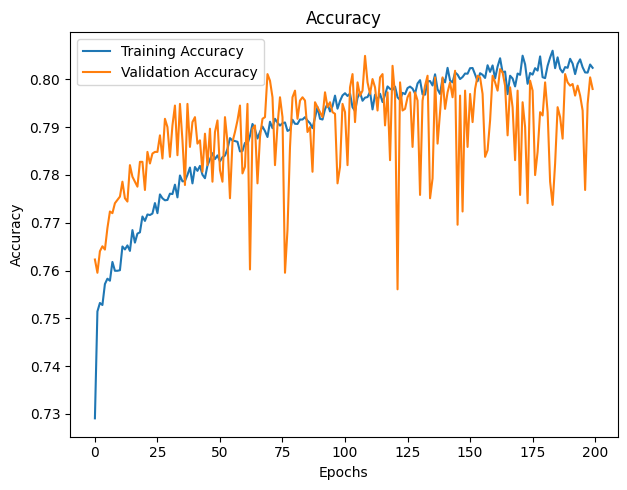

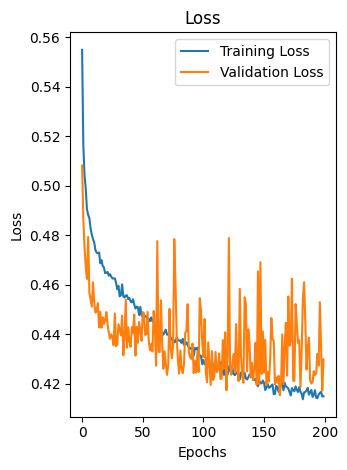

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_accruacies_epoch, label='Training Accuracy')
plt.plot(validation_accruacies_epoch, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 2)
plt.plot(training_losses_epoch, label='Training Loss')
plt.plot(validation_losses_epoch, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Save the model
torch.save(model.state_dict(), "./models/" + model_name + ".pth")

### 12. Generating the submission file.

In [14]:
# Assuming X_test is a DataFrame and device is set to 'cuda'
test_tensor = torch.tensor(X_test.astype(np.float32).values).to(device)
model.eval()

# Perform inference without gradient computation
with torch.no_grad():
    pred_tensor = model(test_tensor)

# Move the tensor to CPU and convert to NumPy
pred = pd.DataFrame(pred_tensor.cpu().numpy(), columns=["bc_price_evo"])

# Convert predictions to integers (0 or 1) and then map to "DOWN" and "UP"
pred["bc_price_evo"] = pred["bc_price_evo"].round().astype(int).map({0: "DOWN", 1: "UP"})

# Create the submission
ids = test_df['id']
submission = pd.concat([ids, pred], axis=1)
submission.to_csv("./submissions/" + model_name + "_submission.csv", index=False)
